# Analysis for Build Components, CogSci 2024

In [294]:
import os
import sys
import urllib, io
import pickle

import random
import numpy as np
import scipy.stats as stats
import pandas as pd
from sklearn.metrics import euclidean_distances, jaccard_score, pairwise_distances

import pymongo as pm
from collections import Counter
import json
import re
import ast

from PIL import Image, ImageOps, ImageDraw, ImageFont 
from IPython.core.display import HTML 

from io import BytesIO
import base64
import requests

import  matplotlib
from matplotlib import pylab, mlab, pyplot
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
from matplotlib.colors import ListedColormap

import seaborn as sns
sns.set_context('talk')
sns.set_style('darkgrid')

from IPython.display import clear_output

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

sys.path.append("../../stimuli/block_utils/")
import blockworld_utils as utils
import domino_settings as dominoes
import domino_settings_monochrome as mono_dominoes

import importlib


In [295]:
experiment_name = 'build_components/cogsci24'

## directory & file hierarchy
proj_dir = os.path.abspath('../..')
datavol_dir = os.path.join(proj_dir,'data')
analysis_dir = os.path.abspath(os.path.join(os.getcwd(),'..'))
results_dir = os.path.join(proj_dir,'results')

# paths specific to this experiment
experiment_results_dir = os.path.join(results_dir, experiment_name)
plot_dir = os.path.join(experiment_results_dir,'plots')
csv_dir = os.path.join(experiment_results_dir,'csv')

## add helpers to python path
if os.path.join(proj_dir,'stimuli') not in sys.path:
    sys.path.append(os.path.join(proj_dir,'stimuli'))
    
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
    
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)   
    
if not os.path.exists(csv_dir):
    os.makedirs(csv_dir)       

In [296]:
# helper functions (extract later)

# Calculate 95% CI for each group
def calculate_ci(data, conf_level=0.95):
    mean = np.mean(data)
    sem = stats.sem(data)
    ci = sem * stats.t.ppf((1 + conf_level) / 2, len(data) - 1)
    return ci

In [297]:
# plot settings

monochrome = True
block_settings = mono_dominoes if monochrome else dominoes
importlib.reload(block_settings)

block_dims = block_settings.block_dims
block_colors = block_settings.block_colors
world_width = block_settings.world_width
world_height = block_settings.world_height
world_center = block_settings.world_center
black = ['#000000','#000000'] # used to display silhouettes
grey = ['#333333','#333333']

In [298]:
# sns.set_context('poster')
# sns.set(font_scale=1.2)
sns.set_style('whitegrid', {'font.family':'sans-serif', 'font.sans-serif':'Avenir'})
import poster_plot_settings
from poster_plot_settings import palette

## read in data

We read in data from 4 sets of csvs, consisting of:  
- 2 encoding tasks: **Visual Exposure (ve)** and **Working Memory (wm)**.  
- 2 decoding tasks: **Recognition/ old-new (on)** and **Building Recall (re)**.  

"Experiments" reported in our paper contain both decoding task for each encoding task i.e. Experiment 1 is VE and Experiment 2 is WM.

In [464]:
# final iteration names are suffixes of csvs

csv_ids = {
    "ve_on" : "build_components_cogsci_ve_old_new_prolific_pilot_0",
    "ve_re": "build_components_cogsci_ve_recall_prolific_pilot_0",
    "wm_on" : "build_components_cogsci_wm_old_new_prolific_pilot_0",
    "wm_re": "build_components_cogsci_wm_recall_prolific_pilot_0"
}

In [465]:
# read in all dataframes

dfs = {}

for i, (k, v) in enumerate(csv_ids.items()):
    dfs[k] = {}
    dfs[k]['encode'] = pd.read_csv(experiment_results_dir + '/df_encode_{}.csv'.format(v))
    dfs[k]['decode'] = pd.read_csv(experiment_results_dir + '/df_decode_{}.csv'.format(v))
    dfs[k]['decode']['responded_old'] = df_recog_ve.response_meaning.apply(lambda x: 1 if x=='old' else 0)
    dfs[k]['block'] = pd.read_csv(experiment_results_dir + '/df_block_{}.csv'.format(v))
    dfs[k]['construct'] = pd.read_csv(experiment_results_dir + '/df_construction_procedure_{}.csv'.format(v))
    
dfs['ve_re']['recalls'] = pd.read_csv(experiment_results_dir + 
                                '/df_recalled_towers_{}.csv'.format(csv_ids['ve_re']))
dfs['wm_re']['recalls'] = pd.read_csv(experiment_results_dir + 
                                '/df_recalled_towers_{}.csv'.format(csv_ids['wm_re']))

In [466]:
# appply exclusion criteria
df = dfs['ve_on']

print('{} ppts to start with'.format(df['encode'].gameID.nunique()))

excluded = []

# didn't complete all encoding trials
incomplete = df['encode'].groupby('gameID').apply(len) < 12
excluded += list(set(incomplete.index[incomplete]))
print('{} ppts removed for incomplete encoding phase'.format(len(list(incomplete.index[incomplete]))))

# didn't complete all decode trials
incomplete_decode = df['decode'].groupby('gameID').apply(len) < 12
excluded += list(incomplete_decode.index[incomplete_decode])
print('{} ppts removed for incomplete decoding phase'.format(len(list(incomplete_decode.index[incomplete_decode]))))

# >90% response with same key
response_mean = df['decode'].groupby('gameID').apply(lambda g: np.mean(g.responded_old))
key_mashing = (response_mean > 0.9) | (response_mean < 0.1)
excluded += list(key_mashing.index[key_mashing])
print('{} ppts removed for key mashing'.format(len(list(key_mashing.index[key_mashing]))))

# 10 mins between end of encode and start of decode
e_time = df['encode'].groupby('gameID').last().reset_index()[['gameID','timeAbsolute']]
d_time = df['decode'].groupby('gameID').first().reset_index()[['gameID','trial_start_time']]
time_diff = e_time.merge(d_time, on = 'gameID', how = 'outer')
time_diff = time_diff[~(time_diff.timeAbsolute.isna() | time_diff.trial_start_time.isna())]
time_diff.loc[:, 'between_phase_time'] = (time_diff.trial_start_time-time_diff.timeAbsolute)/60000
big_wait = (time_diff.loc[:, 'between_phase_time'] > 10)
excluded += list(set((big_wait.index[big_wait])))
print('{} ppts removed for waiting too long between phases'.format(len(list(big_wait.index[big_wait]))))

print('{} ppts remaining'.format(df['encode'][~df['encode'].gameID.isin(excluded)].gameID.nunique()))

56 ppts to start with
6 ppts removed for incomplete encoding phase
0 ppts removed for incomplete decoding phase
0 ppts removed for key mashing
0 ppts removed for waiting too long between phases
50 ppts remaining


In [467]:
# appply exclusion criteria
df = dfs['ve_re']

print('{} ppts to start with'.format(df['encode'].gameID.nunique()))

excluded = []

# didn't complete all encoding trials
incomplete = df['encode'].groupby('gameID').apply(len) < 12
excluded += list(set(incomplete.index[incomplete]))
print('{} ppts removed for incomplete encoding phase'.format(len(list(incomplete.index[incomplete]))))

# didn't complete all decode trials
incomplete_decode = df['decode'].groupby('gameID').apply(len) < 1
excluded += list(incomplete_decode.index[incomplete_decode])
print('{} ppts removed for incomplete decoding phase'.format(len(list(incomplete_decode.index[incomplete_decode]))))

# 10 mins between end of encode and start of decode
e_time = df['encode'].groupby('gameID').last().reset_index()[['gameID','timeAbsolute']]
d_time = df['decode'].groupby('gameID').first().reset_index()[['gameID','trial_start_time']]
time_diff = e_time.merge(d_time, on = 'gameID', how = 'outer')
time_diff = time_diff[~(time_diff.timeAbsolute.isna() | time_diff.trial_start_time.isna())]
time_diff.loc[:, 'between_phase_time'] = (time_diff.trial_start_time-time_diff.timeAbsolute)/60000
big_wait = (time_diff.loc[:, 'between_phase_time'] > 10)
excluded += list(set((big_wait.index[big_wait])))
print('{} ppts removed for waiting too long between phases'.format(len(list(big_wait.index[big_wait]))))

print('{} ppts remaining'.format(df['encode'][~df['encode'].gameID.isin(excluded)].gameID.nunique()))

55 ppts to start with
5 ppts removed for incomplete encoding phase
0 ppts removed for incomplete decoding phase
1 ppts removed for waiting too long between phases
50 ppts remaining


In [468]:
# appply exclusion criteria
df = dfs['wm_on']

print('{} ppts to start with'.format(df['encode'].gameID.nunique()))

excluded = []

# didn't complete all encoding trials
incomplete = df['encode'].groupby('gameID').apply(len) < 24
excluded += list(set(incomplete.index[incomplete]))
print('{} ppts removed for incomplete encoding phase'.format(len(list(incomplete.index[incomplete]))))

# didn't complete all decode trials
incomplete_decode = df['decode'].groupby('gameID').apply(len) < 12
excluded += list(incomplete_decode.index[incomplete_decode])
print('{} ppts removed for incomplete decoding phase'.format(len(list(incomplete_decode.index[incomplete_decode]))))

# >90% response with same key
response_mean = df['decode'].groupby('gameID').apply(lambda g: np.mean(g.responded_old))
key_mashing = (response_mean > 0.9) | (response_mean < 0.1)
excluded += list(key_mashing.index[key_mashing])
print('{} ppts removed for key mashing'.format(len(list(key_mashing.index[key_mashing]))))

# 10 mins between end of encode and start of decode
e_time = df['encode'].groupby('gameID').last().reset_index()[['gameID','timeAbsolute']]
d_time = df['decode'].groupby('gameID').first().reset_index()[['gameID','trial_start_time']]
time_diff = e_time.merge(d_time, on = 'gameID', how = 'outer')
time_diff = time_diff[~(time_diff.timeAbsolute.isna() | time_diff.trial_start_time.isna())]
time_diff.loc[:, 'between_phase_time'] = (time_diff.trial_start_time-time_diff.timeAbsolute)/60000
big_wait = (time_diff.loc[:, 'between_phase_time'] > 10)
excluded += list(set((big_wait.index[big_wait])))
print('{} ppts removed for waiting too long between phases'.format(len(list(big_wait.index[big_wait]))))

print('{} ppts remaining'.format(df['encode'][~df['encode'].gameID.isin(excluded)].gameID.nunique()))

55 ppts to start with
4 ppts removed for incomplete encoding phase
0 ppts removed for incomplete decoding phase
1 ppts removed for key mashing
0 ppts removed for waiting too long between phases
50 ppts remaining


In [469]:
# appply exclusion criteria
df = dfs['wm_re']

print('{} ppts to start with'.format(df['encode'].gameID.nunique()))

excluded = []

# didn't complete all encoding trials
incomplete = df['encode'].groupby('gameID').apply(len) < 24
excluded += list(set(incomplete.index[incomplete]))
print('{} ppts removed for incomplete encoding phase'.format(len(list(incomplete.index[incomplete]))))

# didn't complete all decode trials
incomplete_decode = df['decode'].groupby('gameID').apply(len) < 1
excluded += list(incomplete_decode.index[incomplete_decode])
print('{} ppts removed for incomplete decoding phase'.format(len(list(incomplete_decode.index[incomplete_decode]))))

# 10 mins between end of encode and start of decode
e_time = df['encode'].groupby('gameID').last().reset_index()[['gameID','timeAbsolute']]
d_time = df['decode'].groupby('gameID').first().reset_index()[['gameID','trial_start_time']]
time_diff = e_time.merge(d_time, on = 'gameID', how = 'outer')
time_diff = time_diff[~(time_diff.timeAbsolute.isna() | time_diff.trial_start_time.isna())]
time_diff.loc[:, 'between_phase_time'] = (time_diff.trial_start_time-time_diff.timeAbsolute)/60000
big_wait = (time_diff.loc[:, 'between_phase_time'] > 10)
excluded += list(set((big_wait.index[big_wait])))
print('{} ppts removed for waiting too long between phases'.format(len(list(big_wait.index[big_wait]))))

print('{} ppts remaining'.format(df['encode'][~df['encode'].gameID.isin(excluded)].gameID.nunique()))

51 ppts to start with
1 ppts removed for incomplete encoding phase
0 ppts removed for incomplete decoding phase
0 ppts removed for waiting too long between phases
50 ppts remaining


In [470]:
time_diff = e_time.merge(d_time, on = 'gameID', how = 'outer')
time_diff.loc[:, 'between_phase_time'] = (time_diff.trial_start_time-time_diff.timeAbsolute)/60000

In [471]:
time_diff

,gameID,timeAbsolute,trial_start_time,between_phase_time
0,0285-46809e73-1775-4495-a6bb-f0ed3ea813b4,1.704933e+12,1.704933e+12,0.643250
1,0310-08b09dae-086f-42da-86a4-6632c71bd2c4,1.704927e+12,1.704927e+12,1.069667
2,0322-ea3491ba-48d1-4192-a84d-f5cb440b71f1,1.704927e+12,1.704927e+12,0.402200
3,0324-e049656a-9bb2-44d1-9a68-d3f4c513341d,1.704931e+12,1.704931e+12,0.793067
4,0326-6dcf1204-dd0b-4f95-9ce6-66939403b293,1.704931e+12,1.704931e+12,0.958450
5,0353-73ba71c3-d93b-4b1e-8503-9fda1dcbe961,1.704927e+12,1.704927e+12,0.598367
6,1210-9624ca1c-a98d-4039-bd14-bc4a3a9f1edc,NaN,NaN,NaN
7,1253-c6782ff1-2cce-4023-8f47-11adba0f9799,1.704770e+12,1.704770e+12,0.804733
8,1445-3307ea12-f0c6-42cf-934d-00b841b3670a,1.704927e+12,1.704927e+12,0.524917
9,1453-a220c5f1-f71e-4d6b-aa82-22a39483306c,1.704927e+12,1.704927e+12,0.933533


# Visual Exposure Experiment

## Encoding phase

Contains two conditions, *STUDY* and *COPY*.

No data is recorded in *STUDY*.
Block building data is recorded in *COPY*.

## Decoding phase

Here we can ask our main question: how does encoding condition (*build* vs. *view*) affect memory of a stimulus?

### Recognition (old-new)

In [472]:
df_recog_ve = dfs['ve_on']['decode']
df_recog_ve['novelty'] = ['new' if condition == 'foil' else 'old' for condition in df_recog_ve.condition]
df_recog_ve['responded_old'] = df_recog_ve.response_meaning.apply(lambda x: 1 if x=='old' else 0)

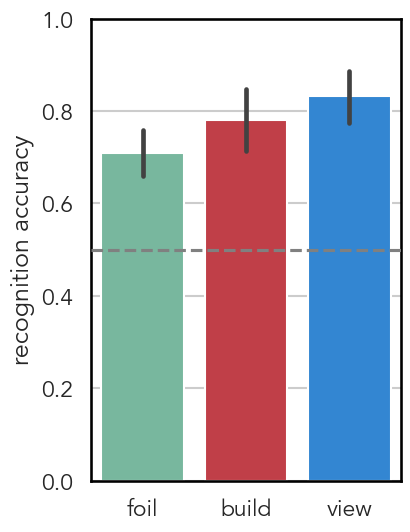

In [473]:
fig, ax = plt.subplots(figsize=(4,6))

# ci_foil  =  calculate_ci(df_recog[df_recog["condition"] == "foil"]["response_correct"])
# ci_build =  calculate_ci(df_recog[df_recog["condition"] == "build"]["response_correct"])
# ci_view  =  calculate_ci(df_recog[df_recog["condition"] == "view"]["response_correct"])
# ci = [ci_foil, ci_build, ci_view]

sns.barplot(data = df_recog_ve, 
            y = "response_correct", 
            x = "condition",
            order = ['foil','build','view'],
            hue = "condition",
#             yerr = ci,
            palette=palette)

plt.legend([],[], frameon=False)


plt.ylim((0,1))
plt.axhline(0.5, color = 'gray', linestyle = '--',)
plt.ylabel('recognition accuracy')
plt.xlabel('')

for spine in fig.gca().spines.values():
    spine.set_zorder(1)
    spine.set_color('black')
plt.savefig(experiment_results_dir + '/plots/ve_on_accuracy.pdf', bbox_inches='tight')
plt.show()

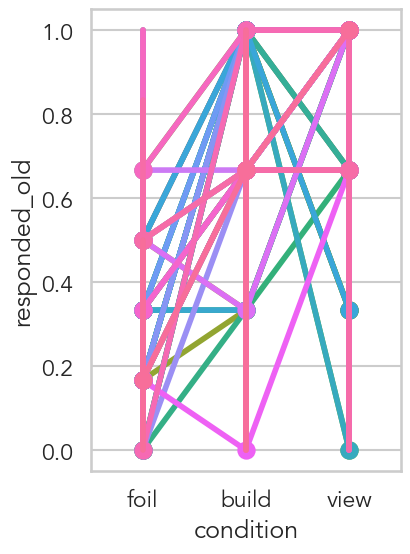

In [304]:
fig, ax = plt.subplots(figsize=(4,6))

# ci_foil  =  calculate_ci(df_recog[df_recog["condition"] == "foil"]["response_correct"])
# ci_build =  calculate_ci(df_recog[df_recog["condition"] == "build"]["response_correct"])
# ci_view  =  calculate_ci(df_recog[df_recog["condition"] == "view"]["response_correct"])
# ci = [ci_foil, ci_build, ci_view]

sns.pointplot(data = df_recog_ve, 
            y = "responded_old", 
            x = "condition",
            order = ['foil','build','view'],
            hue = "gameID")

plt.legend([],[], frameon=False)


# plt.ylim((0,1))
# plt.axhline(0.5, color = 'gray', linestyle = '--',)
# plt.ylabel('recognition accuracy')
# plt.xlabel('')

# for spine in fig.gca().spines.values():
#     spine.set_zorder(1)
#     spine.set_color('black')
# plt.savefig(experiment_results_dir + '/plots/ve_on_accuracy.pdf', bbox_inches='tight')
# plt.show()

/var/folders/4y/_czpmr7d3gb8b80x7wh36g1c0000gn/T/ipykernel_90612/2151579532.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data = df_recog_ve,


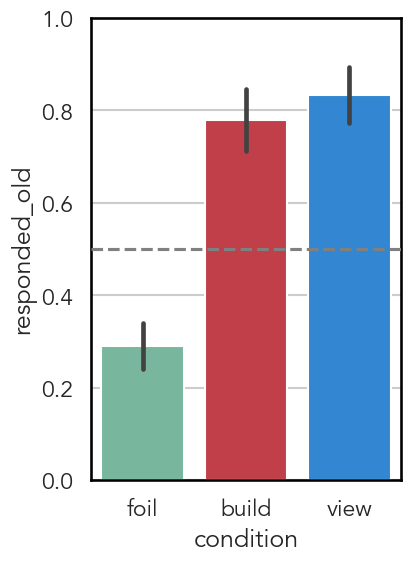

In [305]:
fig = plt.figure()
sns.barplot(data = df_recog_ve, 
            y = "responded_old", 
            order = ['foil','build','view'],
            x = "condition",
            palette=palette)
plt.ylim((0,1))
plt.axhline(0.5, color = 'gray', linestyle = '--',)

for spine in fig.gca().spines.values():
    spine.set_zorder(1)
    spine.set_color('black')

plt.show()

In [306]:
df_recog_ve.columns

Index(['Unnamed: 0', '_id', 'trial_start_time', 'trial_finish_time',
       'relative_time', 'rt', 'condition', 'novelty', 'stimulus', 'response',
       'response_meaning', 'response_correct', 'key_presses', 'trial_num',
       'towerColor', 'distractorKind', 'trial_type', 'trial_index',
       'time_elapsed', 'internal_node_id', 'experimentName', 'iterationName',
       'workerID', 'gameID', 'studyLocation', 'datatype', 'block_str',
       'tower_id', 'tower_A_tall_id', 'tower_A_wide_id', 'tower_B_tall_id',
       'tower_B_wide_id', 'tower_id_tall', 'composite_id', 'responded_old'],
      dtype='object')

In [307]:
df_recog_ve.to_csv(experiment_results_dir + '/df_recog_ve.csv')

### Recall (build from memory)

In [308]:
# helper functions

from sklearn.metrics import f1_score

def f1(arr1, arr2):
    assert arr1.shape == arr2.shape, "The input arrays must have the same shape"
    return f1_score(arr1.ravel(), arr2.ravel())

def distance(t1, t2, metric=f1_score):
    '''
    Returns distance between reconstruction and stim.
    '''
    return distance


def all_distances(t1, t2, metric=f1_score):
    '''
    Returns all distance between reconstruction and stim.
    '''
    return distances


def minimize_distances(t1, t2, metric=f1_score):
    '''
    Returns minimum distances between reconstruction and stim.
    '''
    return distance

def pad_array(arr, n_col, side="left"):
    # Number of rows in the array
    n_rows = arr.shape[0]

    # Create a column of 0s with the same number of rows
    zeros_column = np.zeros((n_rows, n_col))

    # Add the column of 0s to the right side of the array
    if side =="left":
        new_arr = np.hstack((zeros_column, arr))
    elif side =="right":
        new_arr = np.hstack((arr, zeros_column))
    else:
        raise(Exception)

    return new_arr

def translate_tower(arr, dx, dy, fill_value = 0):
    """
    Translate a 2D NumPy array along the x and y axes.

    Args:
        arr (numpy.ndarray): 2D NumPy array.
        dx (int): Number of positions to translate along the x-axis.
        dy (int): Number of positions to translate along the y-axis.

    Returns:
        numpy.ndarray: Translated 2D NumPy array.
    """
    rows, cols = arr.shape
    translated_arr = np.full((rows, cols), fill_value)

    x_start = max(0, dx)
    x_end = cols + min(0, dx)
    y_start = max(0, dy)
    y_end = rows + min(0, dy)

    src_x_start = max(0, -dx)
    src_x_end = cols + min(0, -dx)
    src_y_start = max(0, -dy)
    src_y_end = rows + min(0, -dy)

    translated_arr[y_start:y_end, x_start:x_end] = arr[src_y_start:src_y_end, src_x_start:src_x_end]

    return translated_arr

def best_f1_score(target_tower, recalled_tower, scoring_fn = f1, render = False):
    '''
    Holds target_tower still, and tiles recalled_tower to find the best alignment that maximizes measure.
    Args:
        target_tower and recalled_tower: two arrays of equal dimensions
    
    Returns:
        maximum f1 score
    '''
    
    assert(np.array_equal(target_tower.shape, recalled_tower.shape))
    
    max_score = 0
    best_transformed = None
    overlay_map = None
    best_dx, best_dy = None, None
    
    dy = 0 # only allows dx translation right now
    
    for dx in range(0, target_tower.shape[0]):
        transformed_arr = translate_tower(recalled_tower, dx, dy)
        score = scoring_fn(target_tower, transformed_arr)
        if score > max_score:
                max_score = score
                best_transformed = transformed_arr
                overlay_map = transformed_arr + target_tower*3
                best_dx, best_dy = dx, dy

    if render:
        fig = plt.figure()
        plt.imshow(overlay_map, cmap='inferno')
        fig.gca().axis('off')

                
    return max_score, best_transformed, (best_dx, best_dy)

def leftmost_x(blocks):
    return min([block['x'] for block in blocks])

def translate_tower_x(blocks, n):
    new_blocks = [{'x': block['x'] + n, 'y': block['y'], 'width': block['width'], 'height': block['height']} for block in blocks]
    return new_blocks
    

def align_tower_left(blocks):
    min_x = leftmost_x(blocks)
    new_blocks = translate_tower_x(blocks, -min_x)
    assert leftmost_x(new_blocks) == 0
    return new_blocks

# find max width of recalled tower
def tower_width(block_map):
    index = np.argmax(np.where(block_map.sum(0) > 0))
    width = index + 1 # a little hacky- but should be fine
    return width


def tower_height(block_map):
    index = np.argmax(np.where(block_map.sum(1) > 0))
    height = index + 1
#     height = index + 1 # a little hacky- but should be fine
    return height

In [344]:
df_recalls_ve['blocks']

0      [{'x': 5, 'y': 0, 'width': 1, 'height': 2}, {'...
1      [{'x': 4, 'y': 0, 'width': 1, 'height': 2}, {'...
2      [{'x': 4, 'y': 0, 'width': 1, 'height': 2}, {'...
3      [{'x': 5, 'y': 0, 'width': 2, 'height': 1}, {'...
4      [{'x': 4, 'y': 0, 'width': 2, 'height': 1}, {'...
                             ...                        
219    [{'x': 4, 'y': 0, 'width': 1, 'height': 2}, {'...
220    [{'x': 3, 'y': 0, 'width': 1, 'height': 2}, {'...
222    [{'x': 3, 'y': 0, 'width': 2, 'height': 1}, {'...
223    [{'x': 4, 'y': 0, 'width': 1, 'height': 2}, {'...
224    [{'x': 4, 'y': 0, 'width': 1, 'height': 2}, {'...
Name: blocks, Length: 188, dtype: object

In [345]:
df_recalls_ve = dfs['ve_re']['recalls'].query('endReason != "give-up"')
df_recalls_ve.loc[:,'nTower'] = df_recalls_ve.trial_index-16

/var/folders/4y/_czpmr7d3gb8b80x7wh36g1c0000gn/T/ipykernel_90612/3888844902.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_recalls_ve.loc[:,'nTower'] = df_recalls_ve.trial_index-16


In [346]:
df_recalls_ve.loc[:,'alignedTowerBlocks'] = df_recalls_ve['blocks'].apply(ast.literal_eval).apply(align_tower_left)

/var/folders/4y/_czpmr7d3gb8b80x7wh36g1c0000gn/T/ipykernel_90612/1895220931.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_recalls_ve.loc[:,'alignedTowerBlocks'] = df_recalls_ve['blocks'].apply(ast.literal_eval).apply(align_tower_left)


In [347]:
# find block map aligned to left
df_recalls_ve.loc[:,'alignedRecallMap'] = \
    df_recalls_ve['alignedTowerBlocks'].apply(lambda x: utils.worldify(x, 
                                                                            world_width = 10,
                                                                            world_height = 12).block_map)

# make hashable
df_recalls_ve.loc[:,'alignedRecallMapHashable'] = df_recalls_ve['alignedRecallMap'].apply\
                                                    (lambda block_map: tuple(tuple(row) for row in block_map))


/var/folders/4y/_czpmr7d3gb8b80x7wh36g1c0000gn/T/ipykernel_90612/355368741.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_recalls_ve.loc[:,'alignedRecallMap'] = \
/var/folders/4y/_czpmr7d3gb8b80x7wh36g1c0000gn/T/ipykernel_90612/355368741.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_recalls_ve.loc[:,'alignedRecallMapHashable'] = df_recalls_ve['alignedRecallMap'].apply\


In [348]:
# pad towers with zeros so we can maximize F1 score
max_recall_width = df_recalls_ve['alignedRecallMap'].apply(tower_width).max()
stim_width = 4

print('widest recalled tower is of width ' + str(max_recall_width))
print('world for calculating max f1 score must {} wide'.format(str(max_recall_width + stim_width)))

right_padding = max(0, max_recall_width-6)


max_recall_height = df_recalls_ve['alignedRecallMap'].apply(tower_height).max()
stim_height = 6

print('tallest recalled tower is of height ' + str(max_recall_height))
print('world for calculating max f1 score must {} high'.format(str(max_recall_height + stim_height)))

# remove duplicate towers
remove_duplicates = False

if remove_duplicates:
    # consider towers the same if their corresponding block maps are identical
    df_recalls_ve_unique = df_recalls_ve.sort_values(['nTower']).groupby(['gameID', 'alignedRecallMapHashable']).first().reset_index()

    print("removed {} duplicate towers".format(len(df_recalls_ve) - len(df_recalls_ve_unique)))

    

df_recalls_ve.loc[:,'paddedRecallMap'] = df_recalls_ve['alignedRecallMap'].apply\
                                                (lambda x: pad_array(x, max_recall_width + right_padding, side="right"))


widest recalled tower is of width 8
world for calculating max f1 score must 12 wide
tallest recalled tower is of height 8
world for calculating max f1 score must 14 high


/var/folders/4y/_czpmr7d3gb8b80x7wh36g1c0000gn/T/ipykernel_90612/2844806529.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_recalls_ve.loc[:,'paddedRecallMap'] = df_recalls_ve['alignedRecallMap'].apply\


In [349]:
df_learn_ve_re = dfs['ve_re']['encode']

In [350]:
# center and pad stimuli
df_learn_ve_re.loc[:,'alignedStimulusMap'] = df_learn_ve_re['stimulus']\
                                                .apply(ast.literal_eval)\
                                                .apply(lambda x: utils.worldify(x['blocks'], 
                                                   world_width = 10,
                                                   world_height = 12).block_map)

df_learn_ve_re.loc[:,'alignedStimulusMapHashable'] = df_learn_ve_re['alignedStimulusMap'].apply\
                                                    (lambda block_map: tuple(tuple(row) for row in block_map))

# pad horizontally with zeros  

# add padding to left (max width of recall)
df_learn_ve_re.loc[:,'paddedStimulusMap'] = df_learn_ve_re['alignedStimulusMap'].apply(lambda x: pad_array(x, max_recall_width))

# add padding to right (gap)
df_learn_ve_re.loc[:,'paddedStimulusMap'] = df_learn_ve_re['paddedStimulusMap'].apply(lambda x: pad_array(x, right_padding, side="right"))

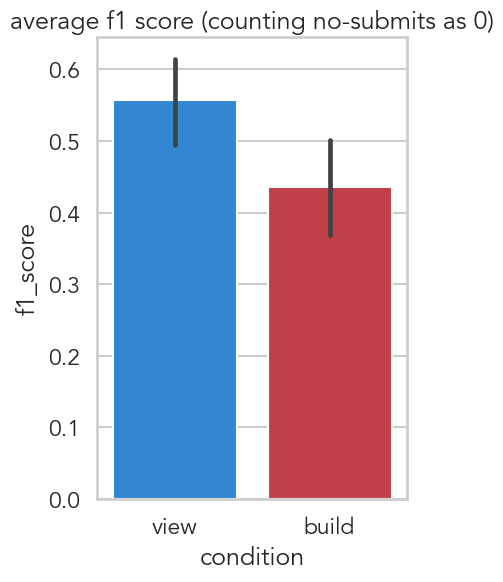

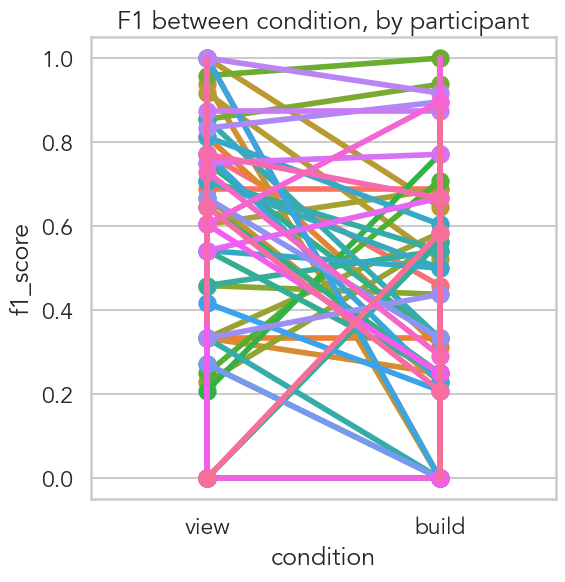

In [360]:
# find stimulus of matching color
df_recalls_ve.loc[:,'color_str'] = df_recalls_ve.color.apply(str)
df_learn_ve_re.loc[:,'color_str'] = df_learn_ve_re.towerColor.apply(str)

df_learn_last_trial = df_learn_ve_re.groupby(['gameID','tower_id_tall']).last().reset_index()

df_color_matched = df_learn_last_trial.merge(df_recalls_ve, 
                                                   how='left', 
                                                   on = ['gameID','color_str'], 
                                                   suffixes=['_learn','_recalled'])

#df_color_matched.rename(columns= {'alignedBlockMaps':'target_block_map'})

df_color_matched.loc[:,'f1_score'] = 0

df_color_matched.loc[~df_color_matched.paddedRecallMap.isna(), 'f1_score'] = \
    df_color_matched.loc[~df_color_matched.paddedRecallMap.isna()].apply(\
            lambda row: best_f1_score(row['paddedStimulusMap'], row['paddedRecallMap'])[0], 
            axis=1)

sns.barplot(df_color_matched,
            x = 'condition',
            hue='condition',
            palette=palette,
            order=["view","build"],
            y = 'f1_score')

plt.title('average f1 score (counting no-submits as 0)')

# diff between F1 condition,

fig = plt.figure(figsize=(6,6))

sns.pointplot(data = df_color_matched,
                y = "f1_score",
                x = "condition",
                hue = "gameID",
                order=["view","build"])

plt.title('F1 between condition, by participant')

plt.legend([],[], frameon=False)

In [317]:
df_color_matched.loc[:,'attempted_recall'] = ~df_color_matched.nTower.isna()
df_color_matched.loc[:,'perfectly_recalled'] = df_color_matched.f1_score == 1

In [318]:
df_encode_w_recalls = df_color_matched
df_encode_w_recalls.to_csv(experiment_results_dir + '/df_encode_w_recalls_ve.csv')

In [319]:
# proportion of view condition towers that were remembered perfectly
np.mean(df_color_matched[df_color_matched.condition=='view'].f1_score == 1)

0.22580645161290322

In [320]:
# proportion of build condition towers that were remembered perfectly
np.mean(df_color_matched[df_color_matched.condition=='build'].f1_score == 1)

0.13333333333333333

(array([68.,  0.,  0.,  0.,  0.,  3., 28., 12., 17., 22.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

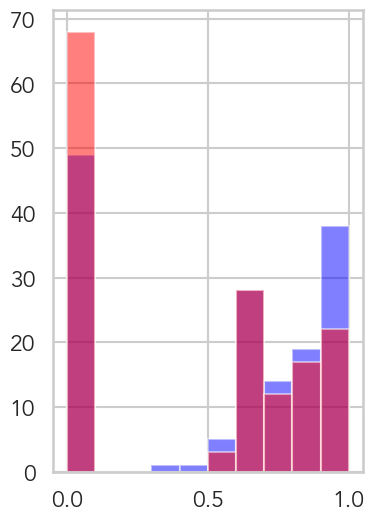

In [321]:
plt.figure()
plt.hist(df_color_matched[df_color_matched.condition=='view'].f1_score, color='blue' , alpha=0.5)
plt.hist(df_color_matched[df_color_matched.condition=='build'].f1_score ,color='red' , alpha=0.5)

(0.6875,
 array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]]),
 (7, 0))

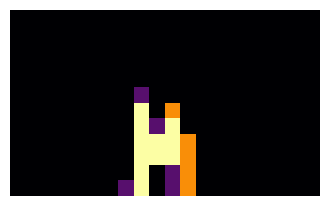

In [322]:
i += 1

test_stim = df_learn_ve_re['alignedStimulusMap'][i]

test_target = df_learn_ve_re['paddedStimulusMap'][i]

test_recall = df_recalls_ve['paddedRecallMap'][i]

best_f1_score(test_target, test_recall, render=True)

# Working Memory Experiment

## Encoding phase

Contains two conditions, *MATCH* and *BUILD*.

#### MATCH

In [323]:
# Accuracy (prop correct) of match (chance is 0.2)


#### BUILD

In [324]:
# Accuracy (F1 score) of reconstruction


## Decoding phase

Decoding phases are identical to that in VE experiment, however we can perform additional analyses based on performance in the encoding phase.

### Recognition (old-new)

In [325]:
df_recog_wm = dfs['wm_on']['decode']
df_recog_wm['novelty'] = ['new' if condition == 'foil' else 'old' for condition in df_recog_wm.condition]
df_recog_wm['responded_old'] = df_recog_wm.response_meaning.apply(lambda x: 1 if x=='old' else 0)

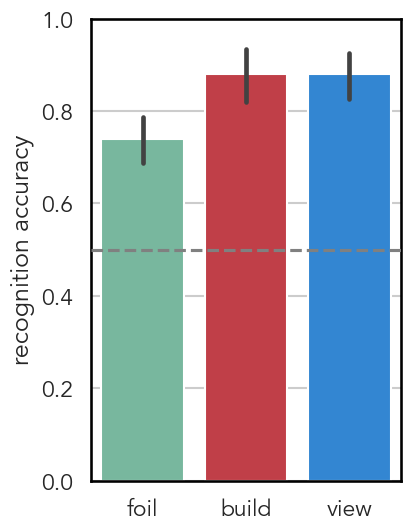

In [327]:
fig, ax = plt.subplots(figsize=(4,6))

sns.barplot(data = df_recog_wm, 
            y = "response_correct", 
            x = "condition",
            order = ['foil','build','view'],
            hue = "condition",
#             yerr = ci,
            palette=palette)

plt.legend([],[], frameon=False)


plt.ylim((0,1))
plt.axhline(0.5, color = 'gray', linestyle = '--',)
plt.ylabel('recognition accuracy')
plt.xlabel('')

for spine in fig.gca().spines.values():
    spine.set_zorder(1)
    spine.set_color('black')
plt.savefig(experiment_results_dir + '/plots/ve_on_accuracy.pdf', bbox_inches='tight')
plt.show()

/var/folders/4y/_czpmr7d3gb8b80x7wh36g1c0000gn/T/ipykernel_90612/3866724668.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data = df_recog_wm,


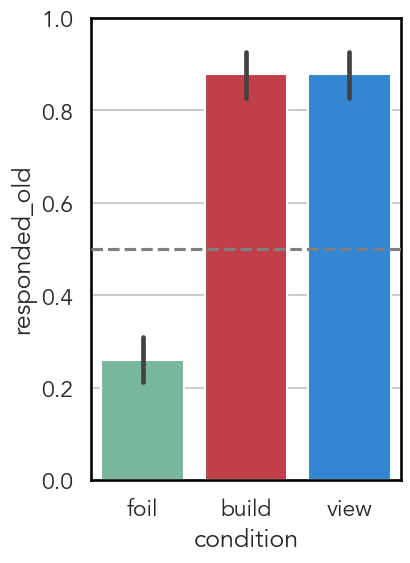

In [328]:
fig = plt.figure()
sns.barplot(data = df_recog_wm, 
            y = "responded_old", 
            order = ['foil','build','view'],
            x = "condition",
            palette=palette)
plt.ylim((0,1))
plt.axhline(0.5, color = 'gray', linestyle = '--',)

for spine in fig.gca().spines.values():
    spine.set_zorder(1)
    spine.set_color('black')

plt.show()

### Recall (build from memory)

In [332]:
df_recalls_wm = dfs['wm_re']['recalls'].query('endReason != "give-up"')
df_recalls_wm.loc[:,'nTower'] = df_recalls_wm.trial_index-28

In [334]:
df_recalls_wm.loc[:,'alignedTowerBlocks'] = df_recalls_wm['blocks'].apply(ast.literal_eval).apply(align_tower_left)

In [335]:
# find block map aligned to left
df_recalls_wm.loc[:,'alignedRecallMap'] = \
    df_recalls_wm['alignedTowerBlocks'].apply(lambda x: utils.worldify(x, 
                                                                            world_width = 10,
                                                                            world_height = 12).block_map)

# make hashable
df_recalls_wm.loc[:,'alignedRecallMapHashable'] = df_recalls_wm['alignedRecallMap'].apply\
                                                    (lambda block_map: tuple(tuple(row) for row in block_map))


/var/folders/4y/_czpmr7d3gb8b80x7wh36g1c0000gn/T/ipykernel_90612/3485150729.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_recalls_wm.loc[:,'alignedRecallMap'] = \
/var/folders/4y/_czpmr7d3gb8b80x7wh36g1c0000gn/T/ipykernel_90612/3485150729.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_recalls_wm.loc[:,'alignedRecallMapHashable'] = df_recalls_wm['alignedRecallMap'].apply\


In [336]:
# pad towers with zeros so we can maximize F1 score
max_recall_width = df_recalls_wm['alignedRecallMap'].apply(tower_width).max()
stim_width = 4

print('widest recalled tower is of width ' + str(max_recall_width))
print('world for calculating max f1 score must {} wide'.format(str(max_recall_width + stim_width)))

right_padding = max(0, max_recall_width-6)


max_recall_height = df_recalls_wm['alignedRecallMap'].apply(tower_height).max()
stim_height = 6

print('tallest recalled tower is of height ' + str(max_recall_height))
print('world for calculating max f1 score must {} high'.format(str(max_recall_height + stim_height)))

# remove duplicate towers
remove_duplicates = False

if remove_duplicates:
    # consider towers the same if their corresponding block maps are identical
    df_recalls_wm_unique = df_recalls_wm.sort_values(['nTower']).groupby(['gameID', 'alignedRecallMapHashable']).first().reset_index()

    print("removed {} duplicate towers".format(len(df_recalls_wm) - len(df_recalls_wm_unique)))

    

df_recalls_wm.loc[:,'paddedRecallMap'] = df_recalls_wm['alignedRecallMap'].apply\
                                                (lambda x: pad_array(x, max_recall_width + right_padding, side="right"))


widest recalled tower is of width 7
world for calculating max f1 score must 11 wide
tallest recalled tower is of height 8
world for calculating max f1 score must 14 high


/var/folders/4y/_czpmr7d3gb8b80x7wh36g1c0000gn/T/ipykernel_90612/575937056.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_recalls_wm.loc[:,'paddedRecallMap'] = df_recalls_wm['alignedRecallMap'].apply\


In [337]:
df_learn_wm_re = dfs['wm_re']['encode']

In [338]:
# center and pad stimuli
df_learn_wm_re.loc[:,'alignedStimulusMap'] = df_learn_wm_re['stimulus']\
                                                .apply(ast.literal_eval)\
                                                .apply(lambda x: utils.worldify(x['blocks'], 
                                                   world_width = 10,
                                                   world_height = 12).block_map)

df_learn_wm_re.loc[:,'alignedStimulusMapHashable'] = df_learn_wm_re['alignedStimulusMap'].apply\
                                                    (lambda block_map: tuple(tuple(row) for row in block_map))

# pad horizontally with zeros  

# add padding to left (max width of recall)
df_learn_wm_re.loc[:,'paddedStimulusMap'] = df_learn_wm_re['alignedStimulusMap'].apply(lambda x: pad_array(x, max_recall_width))

# add padding to right (gap)
df_learn_wm_re.loc[:,'paddedStimulusMap'] = df_learn_wm_re['paddedStimulusMap'].apply(lambda x: pad_array(x, right_padding, side="right"))

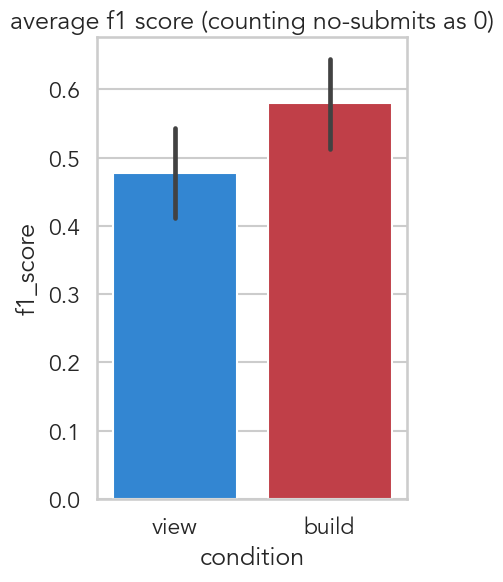

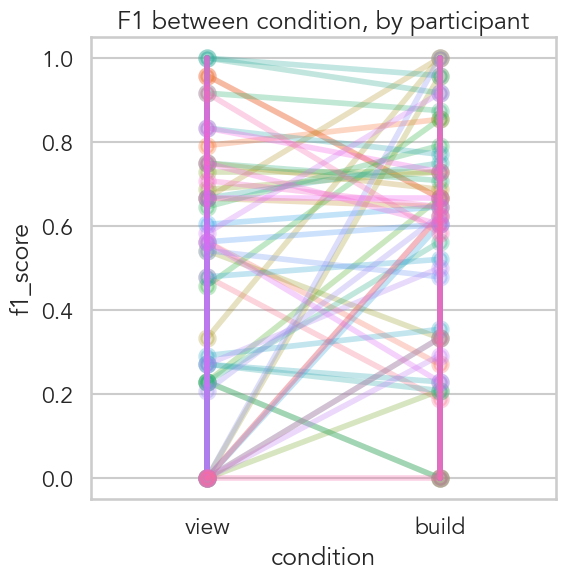

In [359]:
# find stimulus of matching color
df_recalls_wm.loc[:,'color_str'] = df_recalls_wm.color.apply(str)
df_learn_wm_re.loc[:,'color_str'] = df_learn_wm_re.towerColor.apply(str)

df_learn_last_trial = df_learn_wm_re.groupby(['gameID','tower_id_tall']).last().reset_index()

df_color_matched = df_learn_last_trial.merge(df_recalls_wm, 
                                                   how='left', 
                                                   on = ['gameID','color_str'], 
                                                   suffixes=['_learn','_recalled'])

#df_color_matched.rename(columns= {'alignedBlockMaps':'target_block_map'})

df_color_matched.loc[:,'f1_score'] = 0

df_color_matched.loc[~df_color_matched.paddedRecallMap.isna(), 'f1_score'] = \
    df_color_matched.loc[~df_color_matched.paddedRecallMap.isna()].apply(\
            lambda row: best_f1_score(row['paddedStimulusMap'], row['paddedRecallMap'])[0], 
            axis=1)

sns.barplot(df_color_matched,
            x = 'condition',
            hue='condition',
            palette=palette,
            y = 'f1_score')

plt.title('average f1 score (counting no-submits as 0)')

# diff between F1 condition,

fig = plt.figure(figsize=(6,6))

sns.pointplot(data = df_color_matched,
                y = "f1_score",
                x = "condition",
                hue = "gameID",
                order=["view","build"],
                alpha=0.3
             )

plt.title('F1 between condition, by participant')

plt.legend([],[], frameon=False)

In [317]:
df_color_matched.loc[:,'attempted_recall'] = ~df_color_matched.nTower.isna()
df_color_matched.loc[:,'perfectly_recalled'] = df_color_matched.f1_score == 1

In [318]:
df_encode_w_recalls = df_color_matched
df_encode_w_recalls.to_csv(experiment_results_dir + '/df_encode_w_recalls_ve.csv')

In [319]:
# proportion of view condition towers that were remembered perfectly
np.mean(df_color_matched[df_color_matched.condition=='view'].f1_score == 1)

0.22580645161290322

In [320]:
# proportion of build condition towers that were remembered perfectly
np.mean(df_color_matched[df_color_matched.condition=='build'].f1_score == 1)

0.13333333333333333

(array([68.,  0.,  0.,  0.,  0.,  3., 28., 12., 17., 22.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

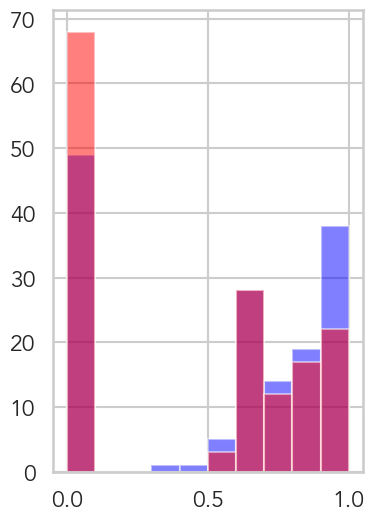

In [321]:
plt.figure()
plt.hist(df_color_matched[df_color_matched.condition=='view'].f1_score, color='blue' , alpha=0.5)
plt.hist(df_color_matched[df_color_matched.condition=='build'].f1_score ,color='red' , alpha=0.5)

(0.6875,
 array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]]),
 (7, 0))

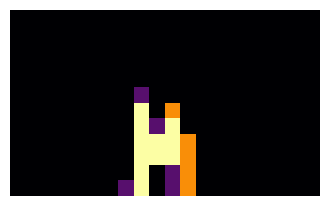

In [322]:
i += 1

test_stim = df_learn_ve_re['alignedStimulusMap'][i]

test_target = df_learn_ve_re['paddedStimulusMap'][i]

test_recall = df_recalls_ve['paddedRecallMap'][i]

best_f1_score(test_target, test_recall, render=True)